In [48]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# -------------------------
# 한글 폰트 설정
# -------------------------
if platform.system() == "Windows":
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕
elif platform.system() == "Darwin":  # macOS
    font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"
else:  # Colab, Linux
    !apt-get -qq -y install fonts-nanum > /dev/null
    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc("font", family=font_name)

# 마이너스 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

print("✅ 한글 폰트 적용 완료:", font_name)

✅ 한글 폰트 적용 완료: Malgun Gothic


In [36]:
import pandas as pd

df = pd.read_csv('제발최종_with_interactions.csv')

In [37]:
df.columns

Index(['축제명', '개최년도', '전체_방문자수', '일평균_방문자수', '시작일', '종료일', '기간일수', '주말일수',
       '숙박일수', '여행유형', '연도', '1일_평균지출액(원)', '1인당_평균지출액(원)', '예상_총지출액(원)',
       '평균기온(°C)', '강수량(mm)', '일조시간(시간)', '교통_접근성_지수', '지역_인구수(천명)',
       '지역_1인당_GRDP(백만원)', '프로그램_개수', '예산(원)', '예산대비_효율성', '소비액_예산비율',
       '축제카테고리', '홍보강도지수', '예산대비_효율성(1천명기준)', '예산x방문자수', '기간x방문자', '방문자_예산비율',
       '주말x숙박'],
      dtype='object')

------------------------전체_방문자수 단일모델------------------

0:	learn: 130532.3651056	test: 130640.1715451	best: 130640.1715451 (0)	total: 27ms	remaining: 21.5s
100:	learn: 7689.6456694	test: 12594.4841699	best: 12594.4841699 (100)	total: 2.54s	remaining: 17.6s
200:	learn: 3214.3769838	test: 9500.0455919	best: 9500.0455919 (200)	total: 5.19s	remaining: 15.5s
300:	learn: 2157.6279647	test: 9019.5569500	best: 9019.5569500 (300)	total: 7.82s	remaining: 13s
400:	learn: 1541.3889420	test: 8861.3851515	best: 8861.3851515 (400)	total: 10.4s	remaining: 10.4s
500:	learn: 1151.6424711	test: 8791.9072806	best: 8791.9072806 (500)	total: 13s	remaining: 7.74s
600:	learn: 872.6973073	test: 8757.5496558	best: 8756.7072852 (599)	total: 15.5s	remaining: 5.13s
700:	learn: 670.4102456	test: 8748.3614803	best: 8748.2136693 (699)	total: 18s	remaining: 2.54s
799:	learn: 532.1099647	test: 8754.1501368	best: 8748.0783518 (711)	total: 20.6s	remaining: 0us

bestTest = 8748.078352
bestIteration = 711

Shrink model to first 712 iterations.
              Model          RMSE 

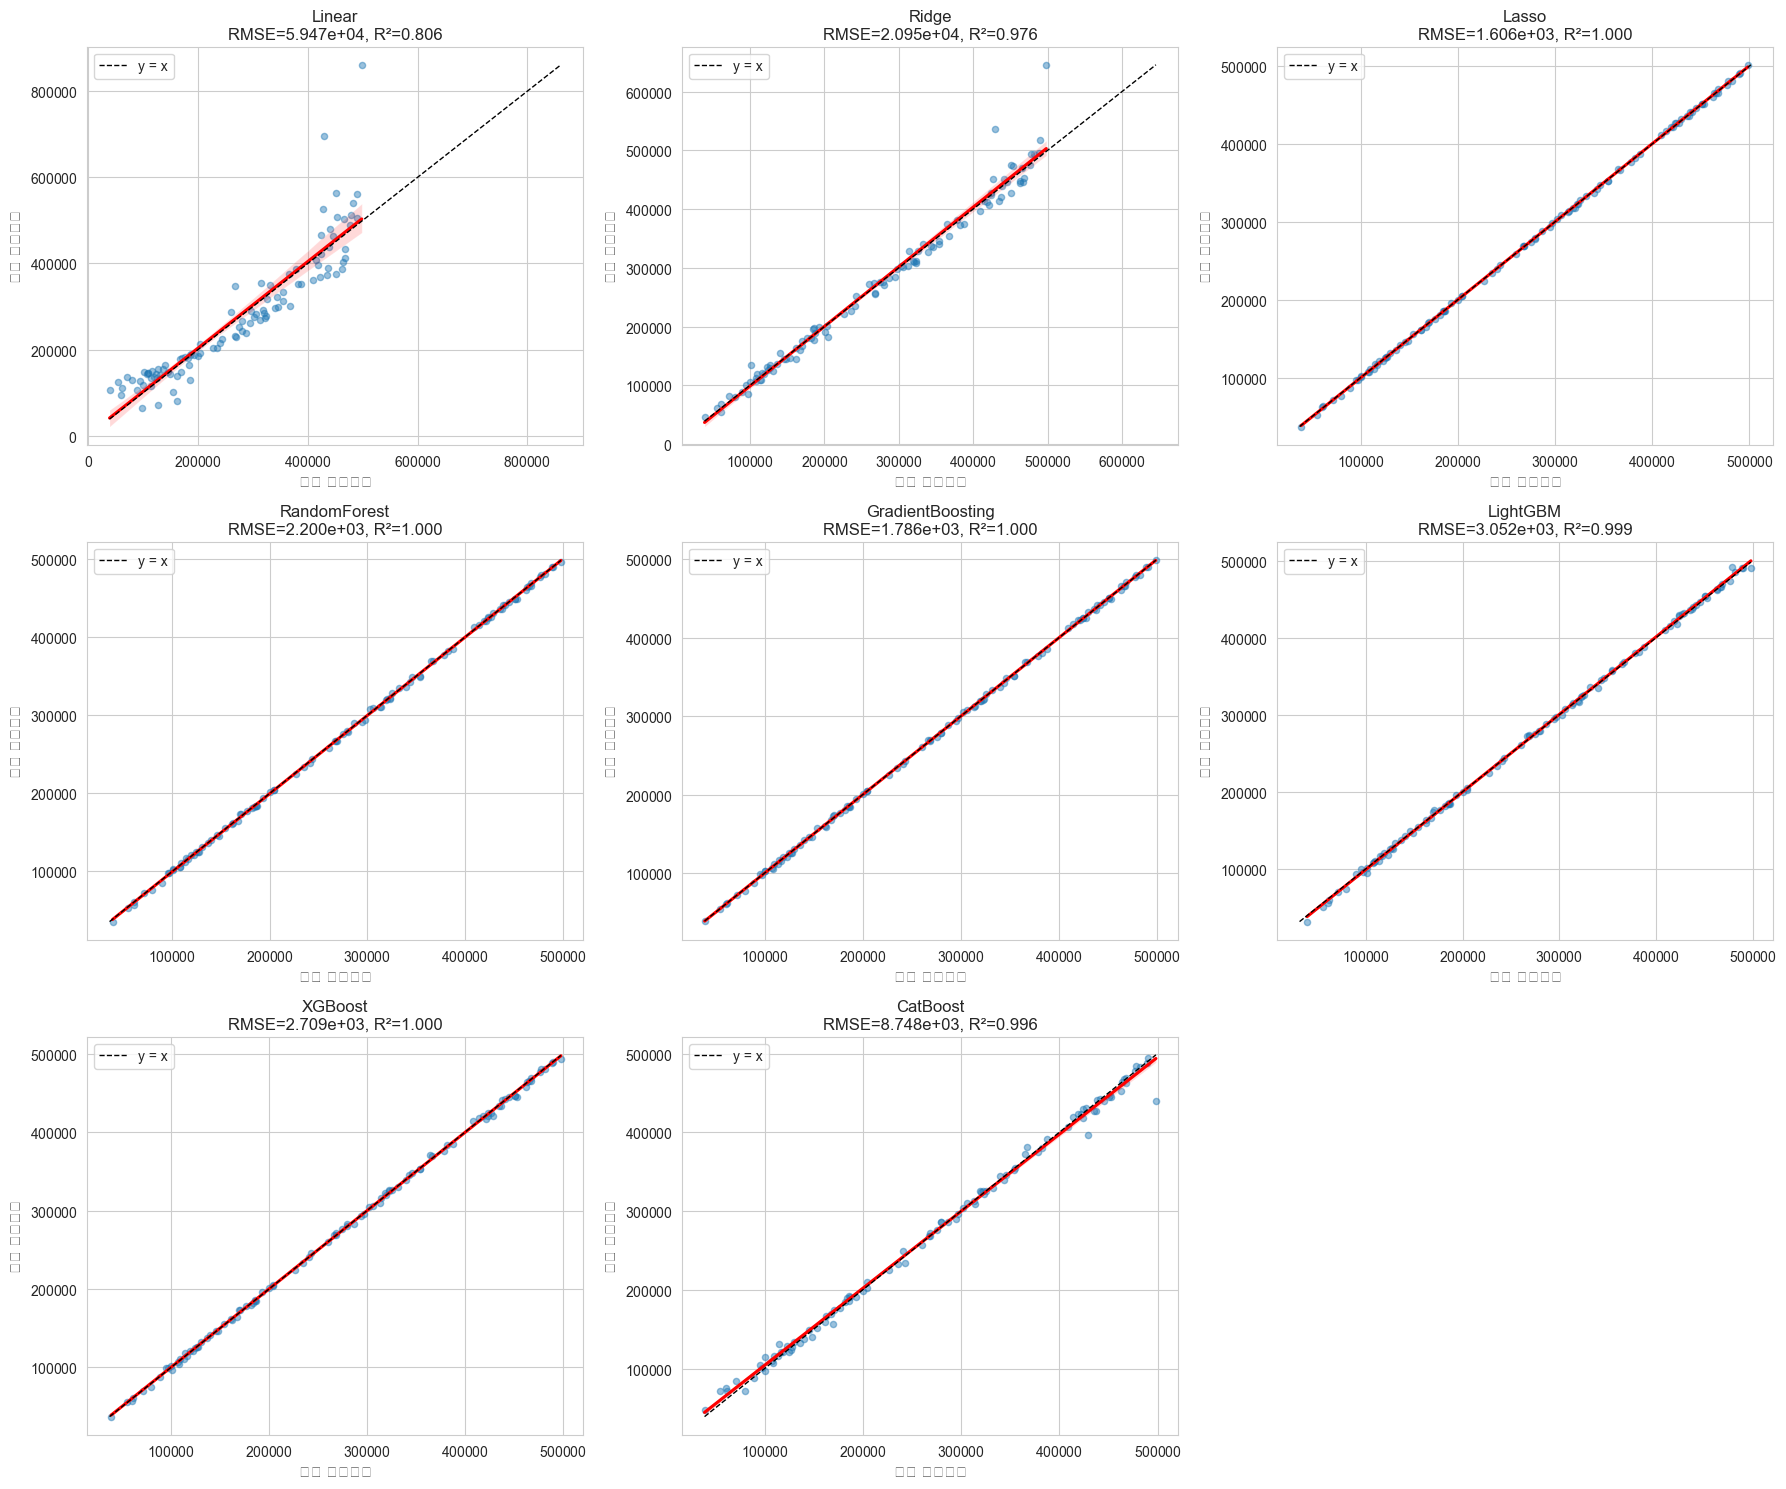

In [38]:
# ==== 설정 ====
CSV_PATH = "제발최종_with_interactions.csv"
TARGET = "전체_방문자수"             # "예상_총지출액"으로 바꿔 다시 돌리면 소비액 예측
ID_COLS = ["축제명"]                  # 식별자는 제거
CAT_COLS = ["축제카테고리"]            # 범주형(문자열) 컬럼
N_JOBS = 16                          # CPU 스레드

# ==== 라이브러리 ====
import warnings, math
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 회귀모델들
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 선택 부스팅들(설치되어 있으면 사용)
try:
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except:
    HAS_LGBM = False

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except:
    HAS_XGB = False

try:
    from catboost import CatBoostRegressor
    HAS_CAT = True
except:
    HAS_CAT = False

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.font_manager as fm

# ==== 한글 폰트 패치(Windows/Mac/Linux 순차 시도) ====
def set_korean_font():
    try:
        plt.rcParams['font.family'] = 'Malgun Gothic'        # Windows
    except:
        try:
            plt.rcParams['font.family'] = 'Apple SD Gothic Neo'  # macOS
        except:
            plt.rcParams['font.family'] = 'NanumGothic'      # Linux
    plt.rcParams['axes.unicode_minus'] = False
set_korean_font()

# ==== 데이터 로드 & 기본 전처리 ====
df = pd.read_csv(CSV_PATH)

# X, y 분리
X = df.drop(columns=[c for c in [TARGET] + ID_COLS if c in df.columns]).copy()
y = df[TARGET].copy()

# LightGBM용 categorical 캐스팅
X_lgbm = X.copy()
for c in CAT_COLS:
    if c in X_lgbm.columns:
        X_lgbm[c] = X_lgbm[c].astype("category")

# OHE 파이프라인 (sklearn/RandomForest/Linear 등용)
num_cols = [c for c in X.columns if c not in CAT_COLS]
ct = ColumnTransformer(
    transformers=[
        ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False), [c for c in CAT_COLS if c in X.columns]),
        ("num", "passthrough", num_cols),
    ]
)

# 데이터 분할(동일 split로 비교)
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=42)
X_tr_lgbm, X_va_lgbm, _, _ = train_test_split(X_lgbm, y, test_size=0.2, random_state=42)

# ==== 모델 정의 ====
models = {}

# OHE 필요 모델들
models["Linear"] = Pipeline([("prep", ct), ("model", LinearRegression())])
models["Ridge"]  = Pipeline([("prep", ct), ("model", Ridge(alpha=1.0))])
models["Lasso"]  = Pipeline([("prep", ct), ("model", Lasso(alpha=0.001))])
models["RandomForest"] = Pipeline([
    ("prep", ct),
    ("model", RandomForestRegressor(n_estimators=500, max_depth=None, n_jobs=N_JOBS, random_state=42))
])
models["GradientBoosting"] = Pipeline([("prep", ct), ("model", GradientBoostingRegressor())])

# LightGBM (네이티브 카테고리)
if HAS_LGBM:
    models["LightGBM"] = ("lgbm_direct", LGBMRegressor(
        n_estimators=800, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9,
        n_jobs=N_JOBS, random_state=42
    ), CAT_COLS)

# XGBoost (OHE 필요)
if HAS_XGB:
    models["XGBoost"] = Pipeline([
        ("prep", ct),
        ("model", XGBRegressor(
            n_estimators=800, learning_rate=0.05, max_depth=6,
            subsample=0.9, colsample_bytree=0.9, n_jobs=N_JOBS, random_state=42
        ))
    ])

# CatBoost (문자열 카테고리 네이티브)
if HAS_CAT:
    cat_idx = [X.columns.get_loc(c) for c in CAT_COLS if c in X.columns]
    models["CatBoost"] = ("cat_direct", CatBoostRegressor(
        iterations=800, learning_rate=0.05, depth=8,
        thread_count=N_JOBS, loss_function="RMSE",
        verbose=100, random_state=42
    ), cat_idx)

# ==== 학습/예측 & 성능 저장 ====
def RMSE(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

results = []
preds_dict = {}

for name, obj in models.items():
    if isinstance(obj, Pipeline):
        obj.fit(X_tr, y_tr)
        pred = obj.predict(X_va)
    else:
        kind, est, info = obj
        if kind == "lgbm_direct":
            est.fit(
                X_tr_lgbm, y_tr,
                eval_set=[(X_va_lgbm, y_va)],
                categorical_feature=info,
                eval_metric="rmse"
            )
            pred = est.predict(X_va_lgbm)
        elif kind == "cat_direct":
            est.fit(X_tr, y_tr, cat_features=info, eval_set=(X_va, y_va))
            pred = est.predict(X_va)
        else:
            raise ValueError("Unknown direct model type")
    preds_dict[name] = pred
    results.append({"Model": name, "RMSE": RMSE(y_va, pred), "R²": r2_score(y_va, pred)})

results_df = pd.DataFrame(results).sort_values("RMSE").reset_index(drop=True)
print(results_df)

# ==== 시각화: 실제값 vs 예측값 + 회귀선 + y=x 기준선 ====
sns.set_style("whitegrid")

M = len(preds_dict)
cols = 3
rows = math.ceil(M / cols)
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
axes = np.array(axes).reshape(rows, cols)

# 과학 표기 줄이기
def _format_axes(ax, title):
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("실제 방문자수", fontsize=11)
    ax.set_ylabel("예측 방문자수", fontsize=11)
    ax.ticklabel_format(style='plain', axis='both')
    ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))

for i, (name, pred) in enumerate(preds_dict.items()):
    r, c = divmod(i, cols)
    ax = axes[r, c]
    # 회귀선 + 산점도
    sns.regplot(x=y_va, y=pred, line_kws={"color":"red"}, scatter_kws={"alpha":0.45, "s":20}, ax=ax)
    # y=x 기준선
    lo = float(min(y_va.min(), pred.min()))
    hi = float(max(y_va.max(), pred.max()))
    ax.plot([lo, hi], [lo, hi], "k--", linewidth=1, label="y = x")
    # 타이틀에 성능 표기
    r_row = results_df[results_df["Model"] == name].iloc[0]
    _format_axes(ax, f"{name}\nRMSE={r_row['RMSE']:.3e}, R²={r_row['R²']:.3f}")
    ax.legend()

# 남는 서브플롯 지우기
for j in range(i+1, rows*cols):
    r, c = divmod(j, cols)
    fig.delaxes(axes[r, c])

plt.tight_layout()
plt.show()


-------------------------전체 방문자수 단일모델--------------------------------------

-------------------------홍보강도지수 단일모델----------------------------------------

0:	learn: 0.2661119	test: 0.2668564	best: 0.2668564 (0)	total: 26.6ms	remaining: 21.3s
100:	learn: 0.0157542	test: 0.0271724	best: 0.0271724 (100)	total: 2.54s	remaining: 17.6s
200:	learn: 0.0073147	test: 0.0216177	best: 0.0216177 (200)	total: 5.11s	remaining: 15.2s
300:	learn: 0.0047753	test: 0.0206718	best: 0.0206718 (300)	total: 7.74s	remaining: 12.8s
400:	learn: 0.0034449	test: 0.0202938	best: 0.0202938 (400)	total: 10.3s	remaining: 10.3s
500:	learn: 0.0026499	test: 0.0200963	best: 0.0200948 (499)	total: 12.9s	remaining: 7.71s
600:	learn: 0.0020317	test: 0.0200117	best: 0.0200117 (600)	total: 15.5s	remaining: 5.13s
700:	learn: 0.0015883	test: 0.0199405	best: 0.0199403 (699)	total: 18.2s	remaining: 2.56s
799:	learn: 0.0013088	test: 0.0199158	best: 0.0199156 (796)	total: 20.8s	remaining: 0us

bestTest = 0.01991559603
bestIteration = 796

Shrink model to first 797 iterations.
              Model      RMSE        R²
0             Lasso  0.003111  0.999872
1      RandomForest  0.003151 

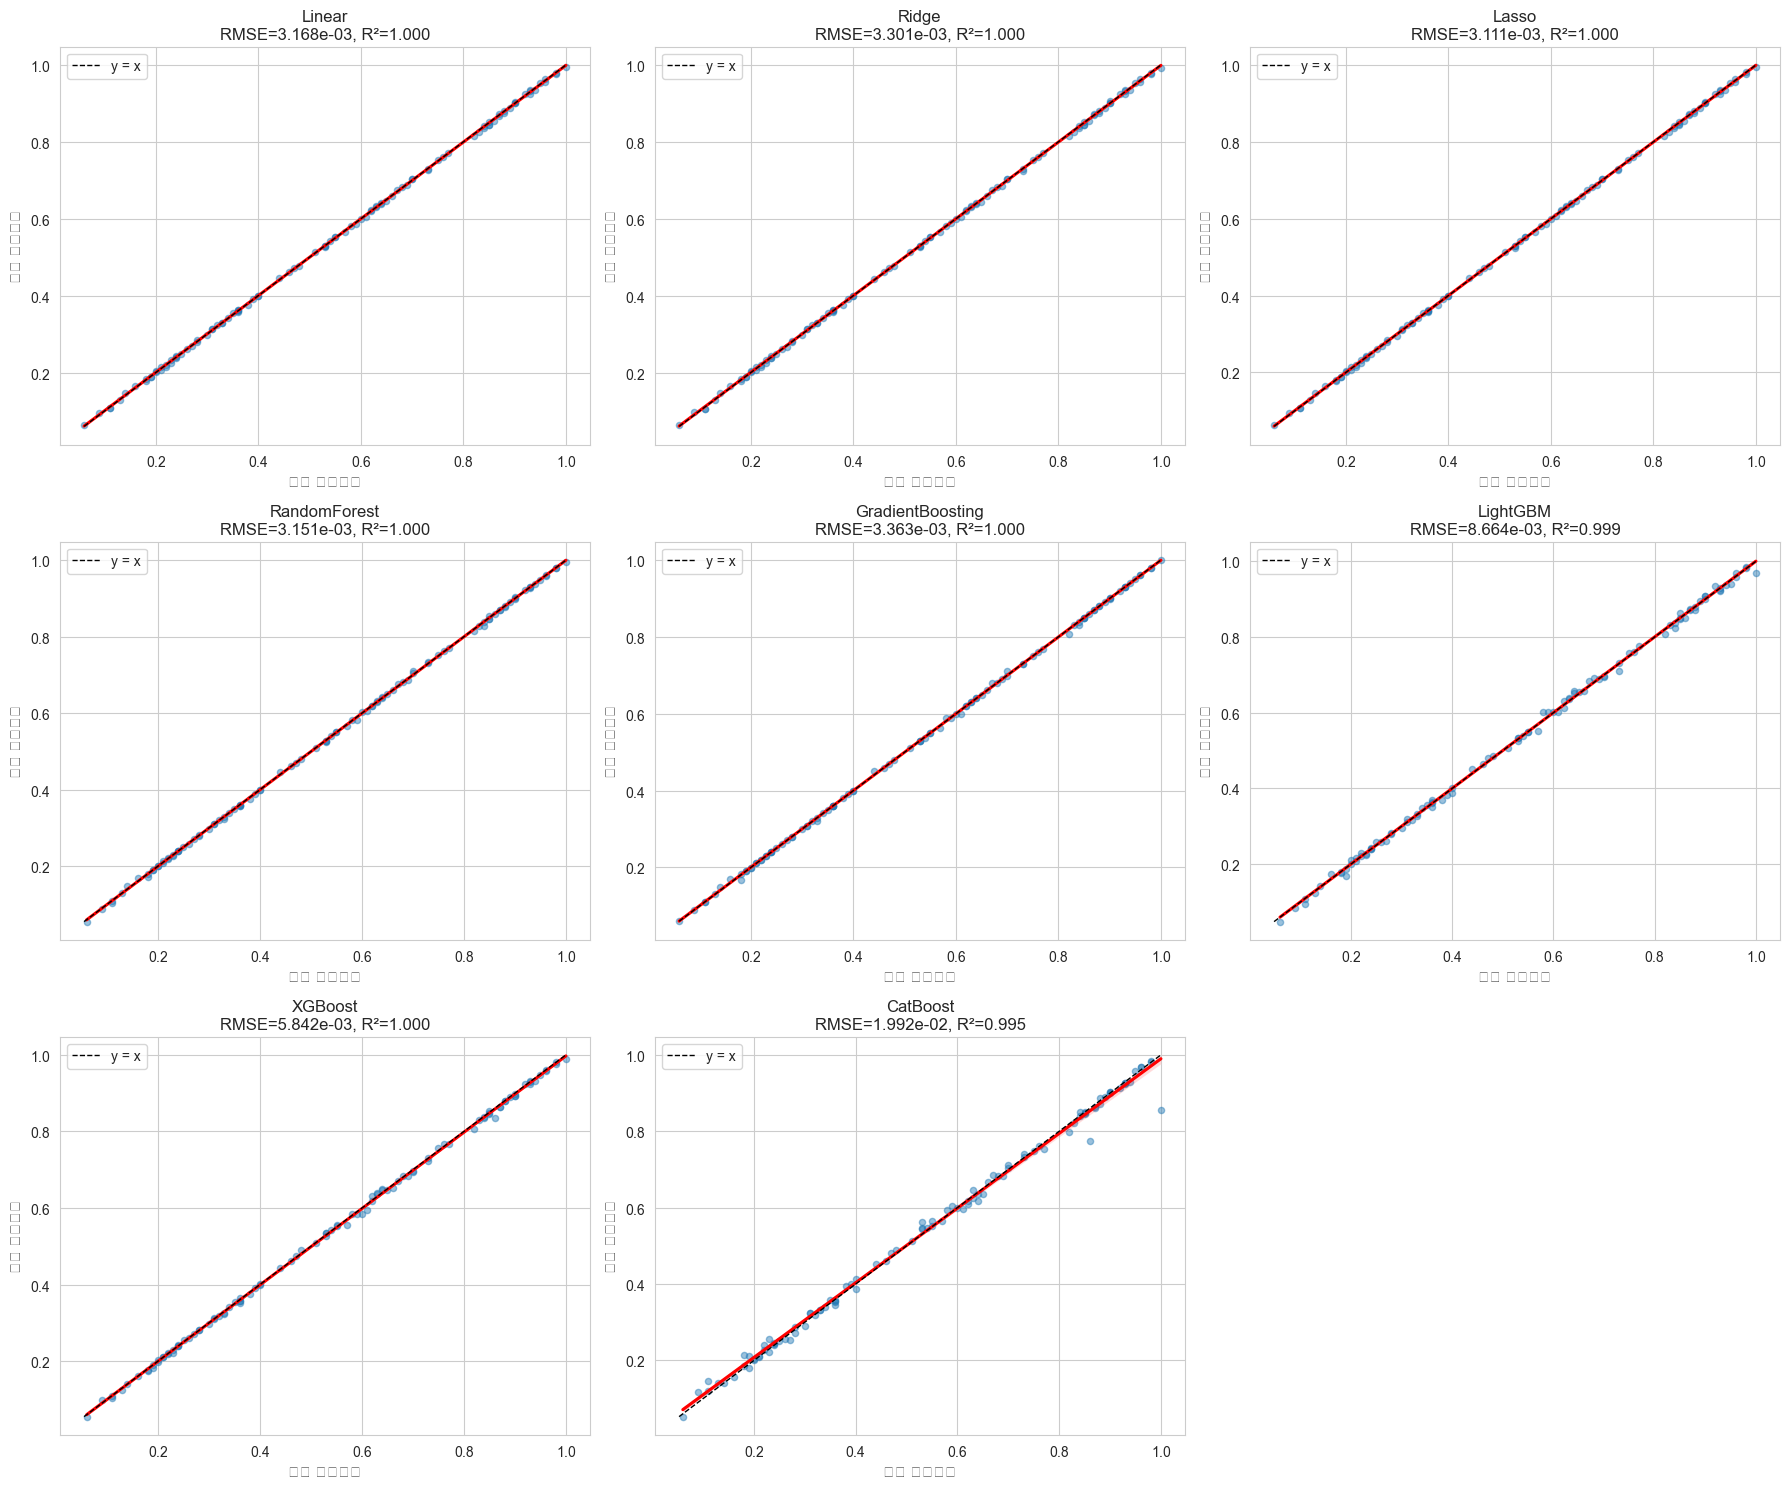

In [39]:
# ==== 설정 ====
CSV_PATH = "제발최종_with_interactions.csv"
TARGET = "홍보강도지수"             # "예상_총지출액"으로 바꿔 다시 돌리면 소비액 예측
ID_COLS = ["축제명"]                  # 식별자는 제거
CAT_COLS = ["축제카테고리"]            # 범주형(문자열) 컬럼
N_JOBS = 16                          # CPU 스레드

# ==== 라이브러리 ====
import warnings, math
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 회귀모델들
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 선택 부스팅들(설치되어 있으면 사용)
try:
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except:
    HAS_LGBM = False

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except:
    HAS_XGB = False

try:
    from catboost import CatBoostRegressor
    HAS_CAT = True
except:
    HAS_CAT = False

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.font_manager as fm

# ==== 한글 폰트 패치(Windows/Mac/Linux 순차 시도) ====
def set_korean_font():
    try:
        plt.rcParams['font.family'] = 'Malgun Gothic'        # Windows
    except:
        try:
            plt.rcParams['font.family'] = 'Apple SD Gothic Neo'  # macOS
        except:
            plt.rcParams['font.family'] = 'NanumGothic'      # Linux
    plt.rcParams['axes.unicode_minus'] = False
set_korean_font()

# ==== 데이터 로드 & 기본 전처리 ====
df = pd.read_csv(CSV_PATH)

# X, y 분리
X = df.drop(columns=[c for c in [TARGET] + ID_COLS if c in df.columns]).copy()
y = df[TARGET].copy()

# LightGBM용 categorical 캐스팅
X_lgbm = X.copy()
for c in CAT_COLS:
    if c in X_lgbm.columns:
        X_lgbm[c] = X_lgbm[c].astype("category")

# OHE 파이프라인 (sklearn/RandomForest/Linear 등용)
num_cols = [c for c in X.columns if c not in CAT_COLS]
ct = ColumnTransformer(
    transformers=[
        ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False), [c for c in CAT_COLS if c in X.columns]),
        ("num", "passthrough", num_cols),
    ]
)

# 데이터 분할(동일 split로 비교)
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=42)
X_tr_lgbm, X_va_lgbm, _, _ = train_test_split(X_lgbm, y, test_size=0.2, random_state=42)

# ==== 모델 정의 ====
models = {}

# OHE 필요 모델들
models["Linear"] = Pipeline([("prep", ct), ("model", LinearRegression())])
models["Ridge"]  = Pipeline([("prep", ct), ("model", Ridge(alpha=1.0))])
models["Lasso"]  = Pipeline([("prep", ct), ("model", Lasso(alpha=0.001))])
models["RandomForest"] = Pipeline([
    ("prep", ct),
    ("model", RandomForestRegressor(n_estimators=500, max_depth=None, n_jobs=N_JOBS, random_state=42))
])
models["GradientBoosting"] = Pipeline([("prep", ct), ("model", GradientBoostingRegressor())])

# LightGBM (네이티브 카테고리)
if HAS_LGBM:
    models["LightGBM"] = ("lgbm_direct", LGBMRegressor(
        n_estimators=800, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9,
        n_jobs=N_JOBS, random_state=42
    ), CAT_COLS)

# XGBoost (OHE 필요)
if HAS_XGB:
    models["XGBoost"] = Pipeline([
        ("prep", ct),
        ("model", XGBRegressor(
            n_estimators=800, learning_rate=0.05, max_depth=6,
            subsample=0.9, colsample_bytree=0.9, n_jobs=N_JOBS, random_state=42
        ))
    ])

# CatBoost (문자열 카테고리 네이티브)
if HAS_CAT:
    cat_idx = [X.columns.get_loc(c) for c in CAT_COLS if c in X.columns]
    models["CatBoost"] = ("cat_direct", CatBoostRegressor(
        iterations=800, learning_rate=0.05, depth=8,
        thread_count=N_JOBS, loss_function="RMSE",
        verbose=100, random_state=42
    ), cat_idx)

# ==== 학습/예측 & 성능 저장 ====
def RMSE(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

results = []
preds_dict = {}

for name, obj in models.items():
    if isinstance(obj, Pipeline):
        obj.fit(X_tr, y_tr)
        pred = obj.predict(X_va)
    else:
        kind, est, info = obj
        if kind == "lgbm_direct":
            est.fit(
                X_tr_lgbm, y_tr,
                eval_set=[(X_va_lgbm, y_va)],
                categorical_feature=info,
                eval_metric="rmse"
            )
            pred = est.predict(X_va_lgbm)
        elif kind == "cat_direct":
            est.fit(X_tr, y_tr, cat_features=info, eval_set=(X_va, y_va))
            pred = est.predict(X_va)
        else:
            raise ValueError("Unknown direct model type")
    preds_dict[name] = pred
    results.append({"Model": name, "RMSE": RMSE(y_va, pred), "R²": r2_score(y_va, pred)})

results_df = pd.DataFrame(results).sort_values("RMSE").reset_index(drop=True)
print(results_df)

# ==== 시각화: 실제값 vs 예측값 + 회귀선 + y=x 기준선 ====
sns.set_style("whitegrid")

M = len(preds_dict)
cols = 3
rows = math.ceil(M / cols)
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
axes = np.array(axes).reshape(rows, cols)

# 과학 표기 줄이기
def _format_axes(ax, title):
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("실제 방문자수", fontsize=11)
    ax.set_ylabel("예측 방문자수", fontsize=11)
    ax.ticklabel_format(style='plain', axis='both')
    ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))

for i, (name, pred) in enumerate(preds_dict.items()):
    r, c = divmod(i, cols)
    ax = axes[r, c]
    # 회귀선 + 산점도
    sns.regplot(x=y_va, y=pred, line_kws={"color":"red"}, scatter_kws={"alpha":0.45, "s":20}, ax=ax)
    # y=x 기준선
    lo = float(min(y_va.min(), pred.min()))
    hi = float(max(y_va.max(), pred.max()))
    ax.plot([lo, hi], [lo, hi], "k--", linewidth=1, label="y = x")
    # 타이틀에 성능 표기
    r_row = results_df[results_df["Model"] == name].iloc[0]
    _format_axes(ax, f"{name}\nRMSE={r_row['RMSE']:.3e}, R²={r_row['R²']:.3f}")
    ax.legend()

# 남는 서브플롯 지우기
for j in range(i+1, rows*cols):
    r, c = divmod(j, cols)
    fig.delaxes(axes[r, c])

plt.tight_layout()
plt.show()


0:	learn: 49239984.1292096	test: 51958901.7830379	best: 51958901.7830379 (0)	total: 28.2ms	remaining: 22.5s
100:	learn: 4090498.4747722	test: 8119003.4543072	best: 8119003.4543072 (100)	total: 2.64s	remaining: 18.3s
200:	learn: 1593752.5336441	test: 5968826.5030172	best: 5968826.5030172 (200)	total: 5.29s	remaining: 15.8s
300:	learn: 967230.9035920	test: 5596885.1284399	best: 5596885.1284399 (300)	total: 7.85s	remaining: 13s
400:	learn: 693483.9969353	test: 5509438.5123760	best: 5509438.5123760 (400)	total: 10.5s	remaining: 10.5s
500:	learn: 506080.2900582	test: 5453895.4186005	best: 5453895.4186005 (500)	total: 13.2s	remaining: 7.9s
600:	learn: 381280.0913474	test: 5431752.8415532	best: 5431607.1152837 (590)	total: 15.9s	remaining: 5.27s
700:	learn: 296569.5090741	test: 5413847.5511563	best: 5413030.9438999 (697)	total: 18.6s	remaining: 2.63s
799:	learn: 237401.0842250	test: 5401165.1849206	best: 5401165.1849206 (799)	total: 21.2s	remaining: 0us

bestTest = 5401165.185
bestIteration =

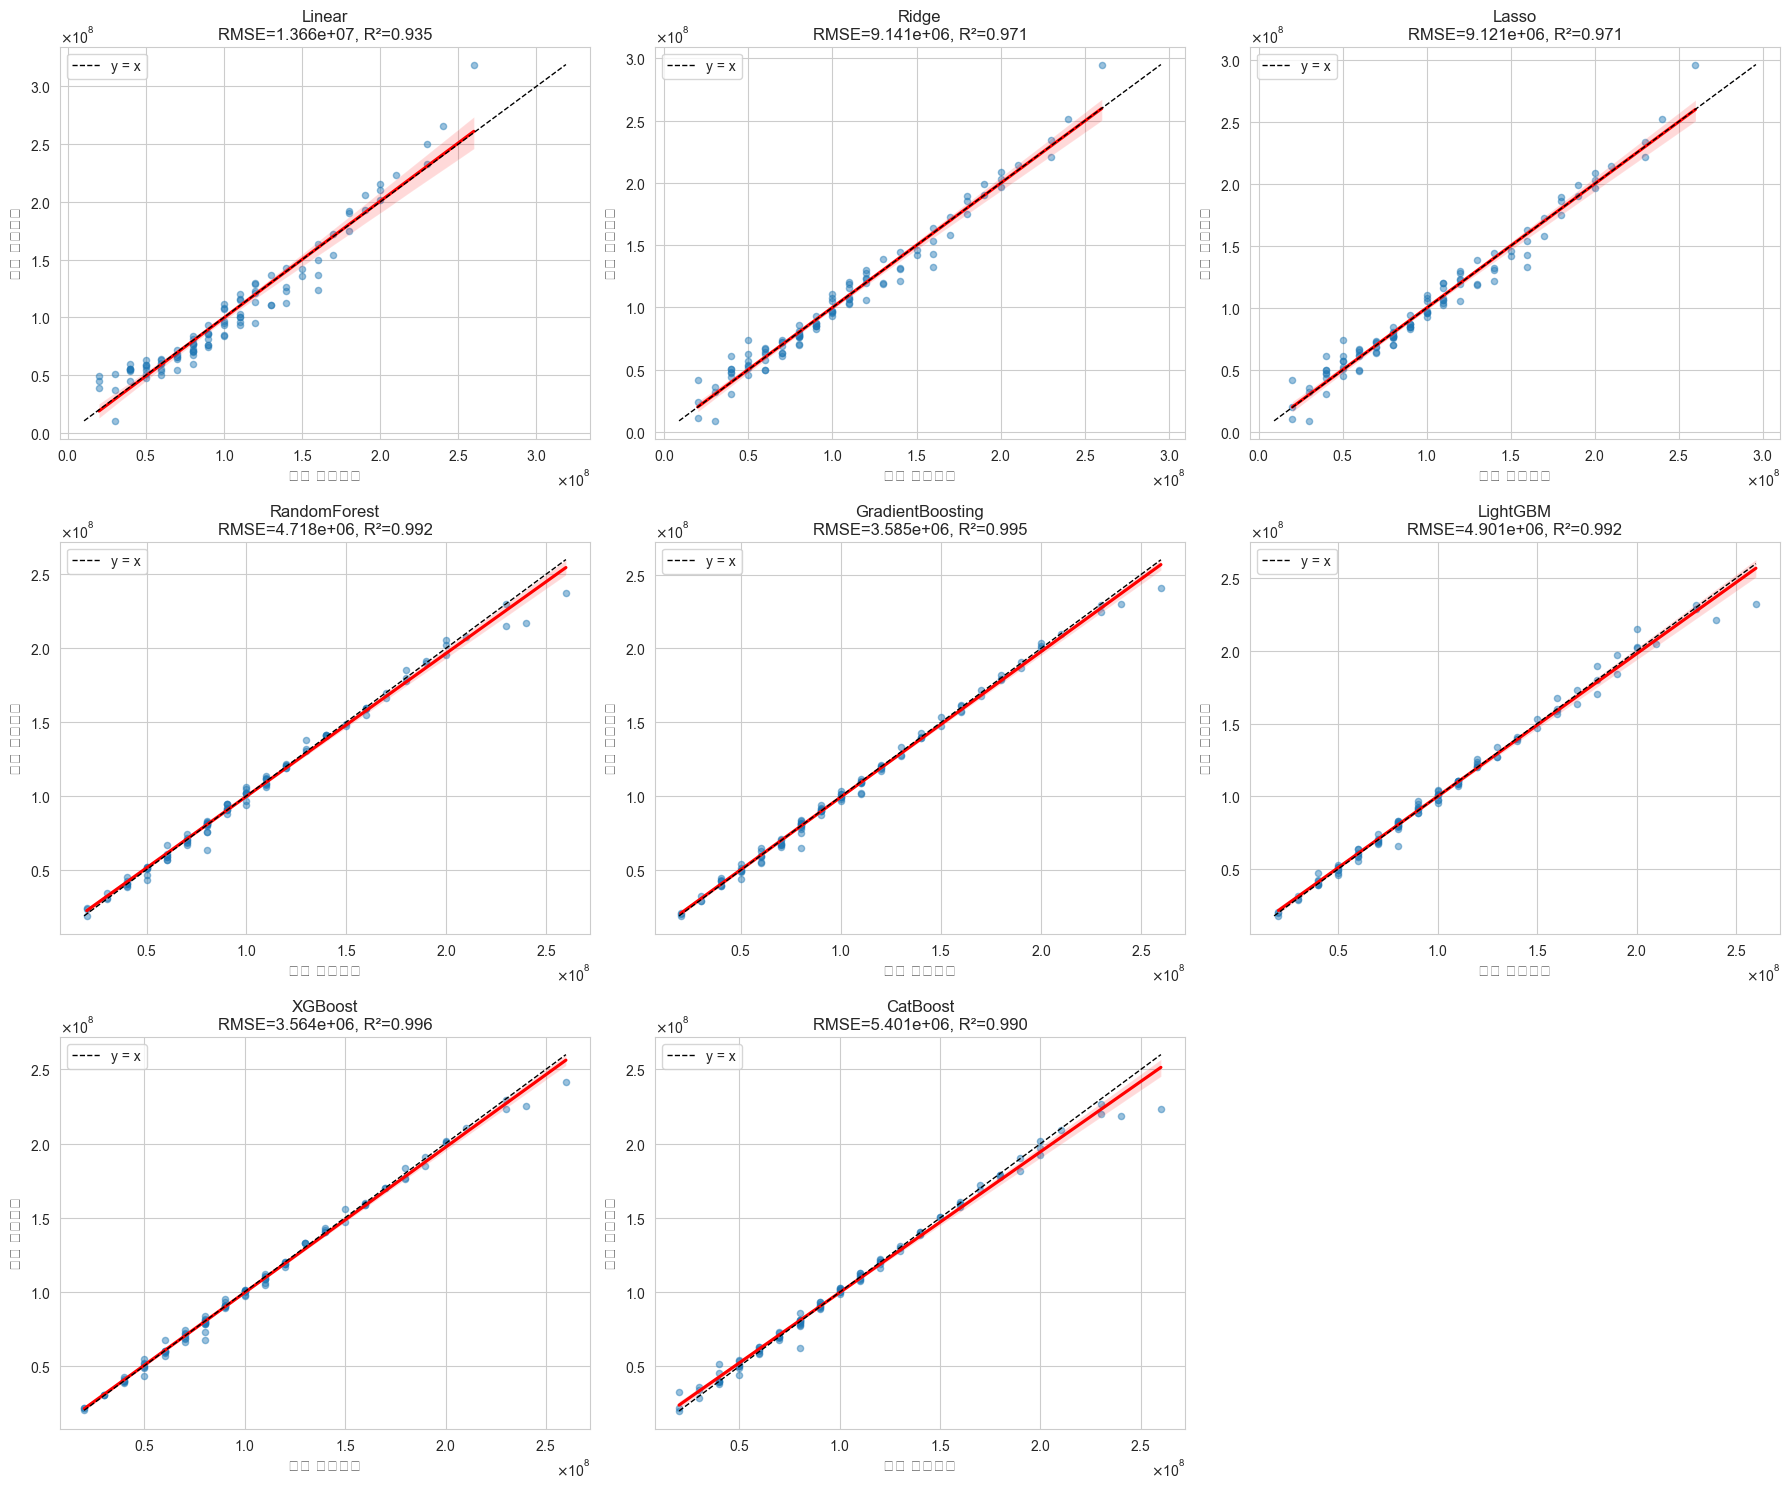

In [42]:
# ==== 설정 ====
CSV_PATH = "제발최종_with_interactions.csv"
TARGET = "예산(원)"             # "예상_총지출액"으로 바꿔 다시 돌리면 소비액 예측
ID_COLS = ["축제명"]                  # 식별자는 제거
CAT_COLS = ["축제카테고리"]            # 범주형(문자열) 컬럼
N_JOBS = 16                          # CPU 스레드

# ==== 라이브러리 ====
import warnings, math
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 회귀모델들
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 선택 부스팅들(설치되어 있으면 사용)
try:
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except:
    HAS_LGBM = False

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except:
    HAS_XGB = False

try:
    from catboost import CatBoostRegressor
    HAS_CAT = True
except:
    HAS_CAT = False

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.font_manager as fm

# ==== 한글 폰트 패치(Windows/Mac/Linux 순차 시도) ====
def set_korean_font():
    try:
        plt.rcParams['font.family'] = 'Malgun Gothic'        # Windows
    except:
        try:
            plt.rcParams['font.family'] = 'Apple SD Gothic Neo'  # macOS
        except:
            plt.rcParams['font.family'] = 'NanumGothic'      # Linux
    plt.rcParams['axes.unicode_minus'] = False
set_korean_font()

# ==== 데이터 로드 & 기본 전처리 ====
df = pd.read_csv(CSV_PATH)

# X, y 분리
X = df.drop(columns=[c for c in [TARGET] + ID_COLS if c in df.columns]).copy()
y = df[TARGET].copy()

# LightGBM용 categorical 캐스팅
X_lgbm = X.copy()
for c in CAT_COLS:
    if c in X_lgbm.columns:
        X_lgbm[c] = X_lgbm[c].astype("category")

# OHE 파이프라인 (sklearn/RandomForest/Linear 등용)
num_cols = [c for c in X.columns if c not in CAT_COLS]
ct = ColumnTransformer(
    transformers=[
        ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False), [c for c in CAT_COLS if c in X.columns]),
        ("num", "passthrough", num_cols),
    ]
)

# 데이터 분할(동일 split로 비교)
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=42)
X_tr_lgbm, X_va_lgbm, _, _ = train_test_split(X_lgbm, y, test_size=0.2, random_state=42)

# ==== 모델 정의 ====
models = {}

# OHE 필요 모델들
models["Linear"] = Pipeline([("prep", ct), ("model", LinearRegression())])
models["Ridge"]  = Pipeline([("prep", ct), ("model", Ridge(alpha=1.0))])
models["Lasso"]  = Pipeline([("prep", ct), ("model", Lasso(alpha=0.001))])
models["RandomForest"] = Pipeline([
    ("prep", ct),
    ("model", RandomForestRegressor(n_estimators=500, max_depth=None, n_jobs=N_JOBS, random_state=42))
])
models["GradientBoosting"] = Pipeline([("prep", ct), ("model", GradientBoostingRegressor())])

# LightGBM (네이티브 카테고리)
if HAS_LGBM:
    models["LightGBM"] = ("lgbm_direct", LGBMRegressor(
        n_estimators=800, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9,
        n_jobs=N_JOBS, random_state=42
    ), CAT_COLS)

# XGBoost (OHE 필요)
if HAS_XGB:
    models["XGBoost"] = Pipeline([
        ("prep", ct),
        ("model", XGBRegressor(
            n_estimators=800, learning_rate=0.05, max_depth=6,
            subsample=0.9, colsample_bytree=0.9, n_jobs=N_JOBS, random_state=42
        ))
    ])

# CatBoost (문자열 카테고리 네이티브)
if HAS_CAT:
    cat_idx = [X.columns.get_loc(c) for c in CAT_COLS if c in X.columns]
    models["CatBoost"] = ("cat_direct", CatBoostRegressor(
        iterations=800, learning_rate=0.05, depth=8,
        thread_count=N_JOBS, loss_function="RMSE",
        verbose=100, random_state=42
    ), cat_idx)

# ==== 학습/예측 & 성능 저장 ====
def RMSE(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

results = []
preds_dict = {}

for name, obj in models.items():
    if isinstance(obj, Pipeline):
        obj.fit(X_tr, y_tr)
        pred = obj.predict(X_va)
    else:
        kind, est, info = obj
        if kind == "lgbm_direct":
            est.fit(
                X_tr_lgbm, y_tr,
                eval_set=[(X_va_lgbm, y_va)],
                categorical_feature=info,
                eval_metric="rmse"
            )
            pred = est.predict(X_va_lgbm)
        elif kind == "cat_direct":
            est.fit(X_tr, y_tr, cat_features=info, eval_set=(X_va, y_va))
            pred = est.predict(X_va)
        else:
            raise ValueError("Unknown direct model type")
    preds_dict[name] = pred
    results.append({"Model": name, "RMSE": RMSE(y_va, pred), "R²": r2_score(y_va, pred)})

results_df = pd.DataFrame(results).sort_values("RMSE").reset_index(drop=True)
print(results_df)

# ==== 시각화: 실제값 vs 예측값 + 회귀선 + y=x 기준선 ====
sns.set_style("whitegrid")

M = len(preds_dict)
cols = 3
rows = math.ceil(M / cols)
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
axes = np.array(axes).reshape(rows, cols)

# 과학 표기 줄이기
def _format_axes(ax, title):
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("실제 방문자수", fontsize=11)
    ax.set_ylabel("예측 방문자수", fontsize=11)
    ax.ticklabel_format(style='plain', axis='both')
    ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))

for i, (name, pred) in enumerate(preds_dict.items()):
    r, c = divmod(i, cols)
    ax = axes[r, c]
    # 회귀선 + 산점도
    sns.regplot(x=y_va, y=pred, line_kws={"color":"red"}, scatter_kws={"alpha":0.45, "s":20}, ax=ax)
    # y=x 기준선
    lo = float(min(y_va.min(), pred.min()))
    hi = float(max(y_va.max(), pred.max()))
    ax.plot([lo, hi], [lo, hi], "k--", linewidth=1, label="y = x")
    # 타이틀에 성능 표기
    r_row = results_df[results_df["Model"] == name].iloc[0]
    _format_axes(ax, f"{name}\nRMSE={r_row['RMSE']:.3e}, R²={r_row['R²']:.3f}")
    ax.legend()

# 남는 서브플롯 지우기
for j in range(i+1, rows*cols):
    r, c = divmod(j, cols)
    fig.delaxes(axes[r, c])

plt.tight_layout()
plt.show()


0:	learn: 0.6381717	test: 0.5636704	best: 0.5636704 (0)	total: 35.4ms	remaining: 28.3s
100:	learn: 0.0886016	test: 0.2434259	best: 0.2434259 (100)	total: 2.69s	remaining: 18.6s
200:	learn: 0.0200384	test: 0.2282580	best: 0.2281366 (193)	total: 5.4s	remaining: 16.1s
300:	learn: 0.0081477	test: 0.2285194	best: 0.2280860 (215)	total: 8.04s	remaining: 13.3s
400:	learn: 0.0046797	test: 0.2284911	best: 0.2280860 (215)	total: 10.7s	remaining: 10.6s
500:	learn: 0.0030078	test: 0.2282832	best: 0.2280860 (215)	total: 13.3s	remaining: 7.95s
600:	learn: 0.0019933	test: 0.2282078	best: 0.2280860 (215)	total: 15.9s	remaining: 5.26s
700:	learn: 0.0014308	test: 0.2282063	best: 0.2280860 (215)	total: 18.5s	remaining: 2.61s
799:	learn: 0.0010874	test: 0.2282107	best: 0.2280860 (215)	total: 21.2s	remaining: 0us

bestTest = 0.2280859522
bestIteration = 215

Shrink model to first 216 iterations.
              Model      RMSE        R²
0          LightGBM  0.156986  0.926427
1           XGBoost  0.164345  0

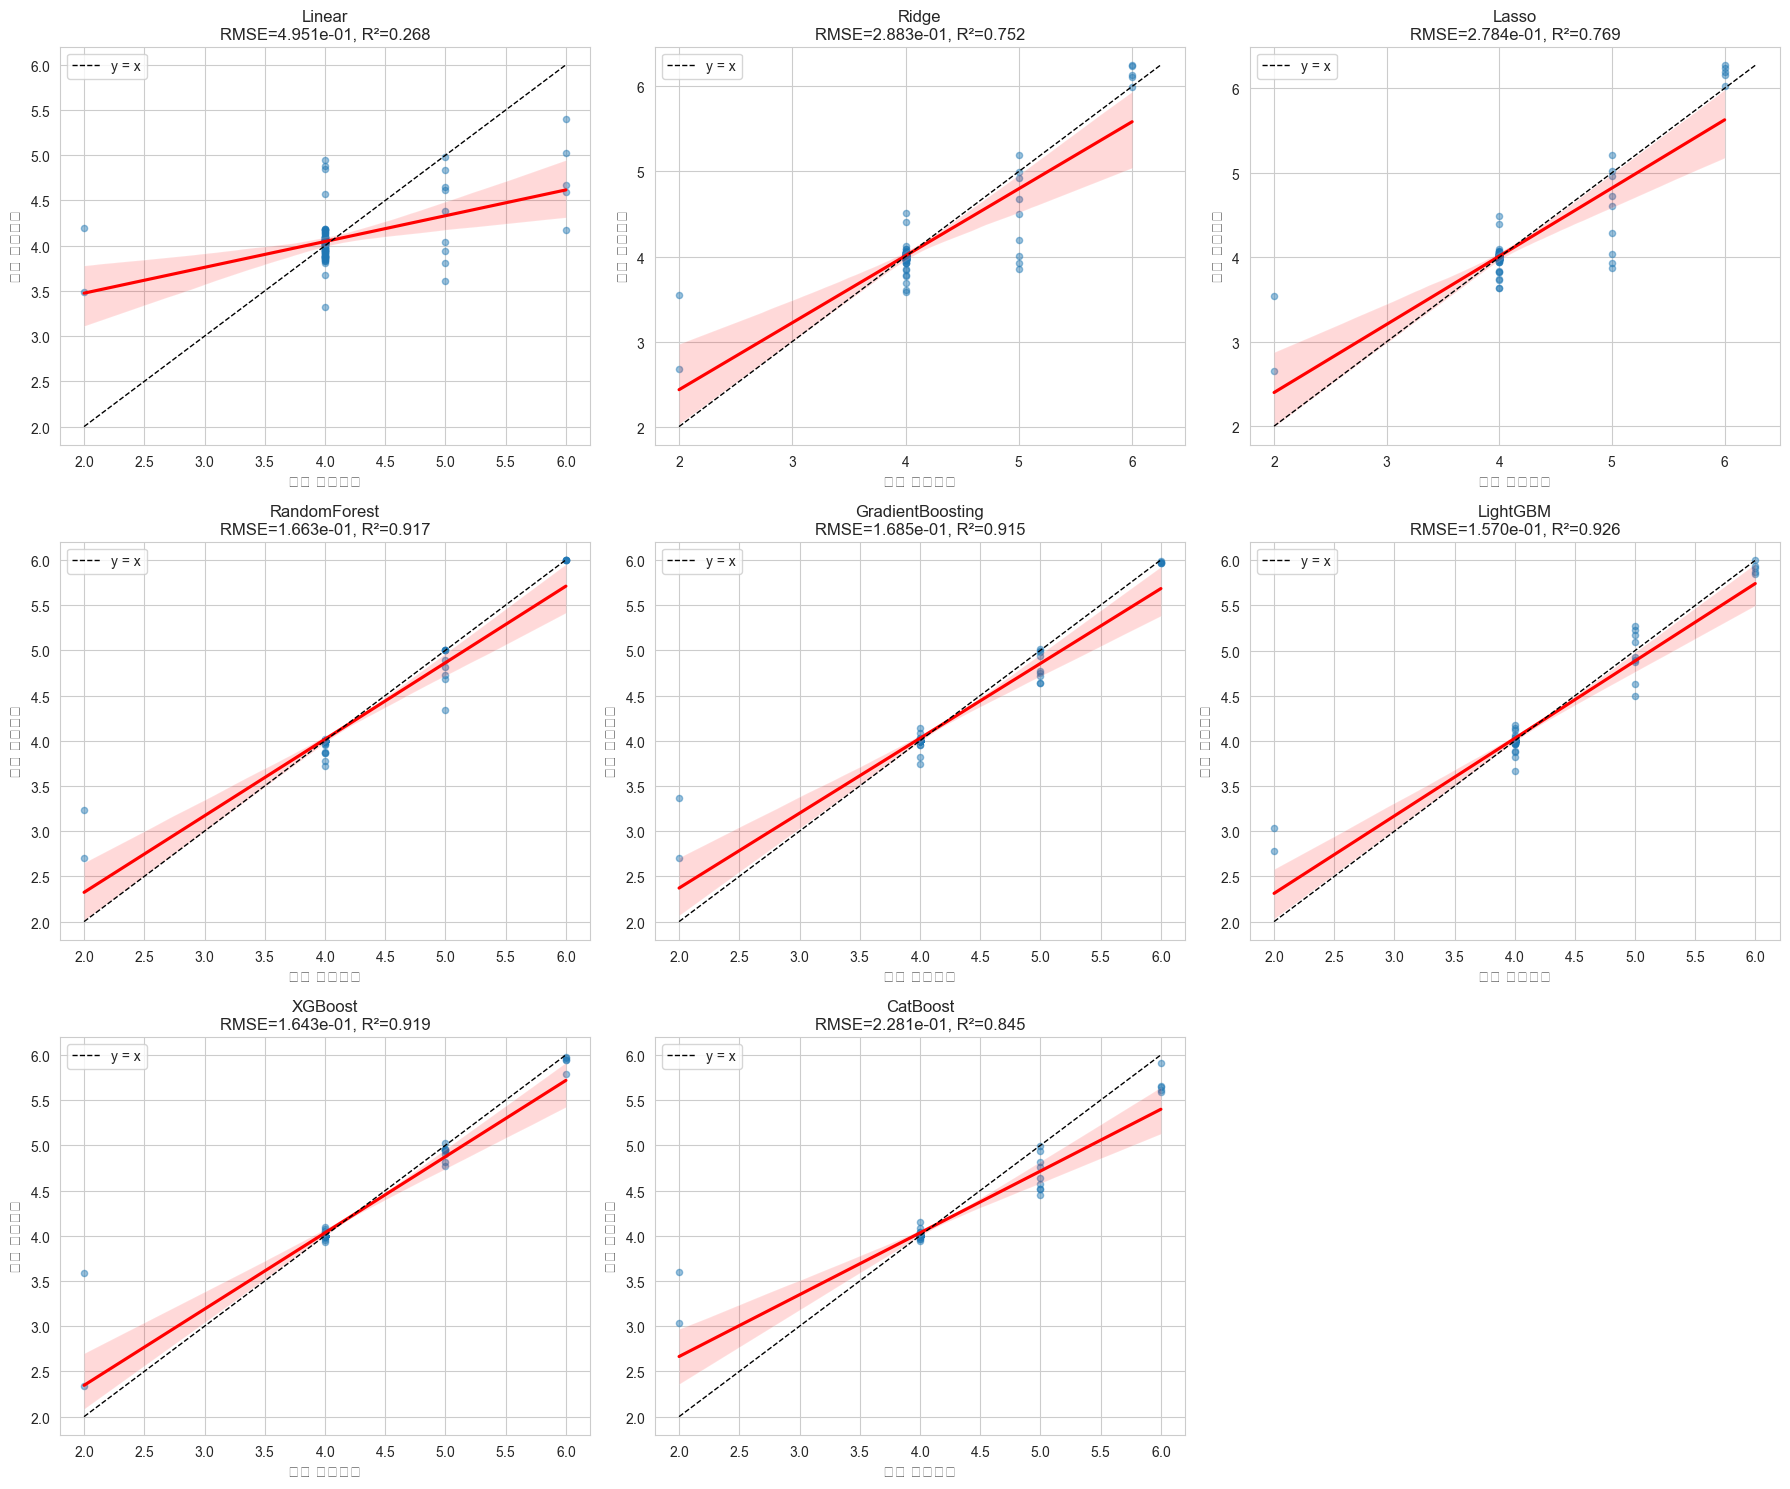

In [50]:
# ==== 설정 ====
CSV_PATH = "제발최종_with_interactions.csv"
TARGET = "숙박일수"             # "예상_총지출액"으로 바꿔 다시 돌리면 소비액 예측
ID_COLS = ["축제명"]                  # 식별자는 제거
CAT_COLS = ["축제카테고리"]            # 범주형(문자열) 컬럼
N_JOBS = 16                          # CPU 스레드

# ==== 라이브러리 ====
import warnings, math
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 회귀모델들
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 선택 부스팅들(설치되어 있으면 사용)
try:
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except:
    HAS_LGBM = False

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except:
    HAS_XGB = False

try:
    from catboost import CatBoostRegressor
    HAS_CAT = True
except:
    HAS_CAT = False

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.font_manager as fm

# ==== 한글 폰트 패치(Windows/Mac/Linux 순차 시도) ====
def set_korean_font():
    try:
        plt.rcParams['font.family'] = 'Malgun Gothic'        # Windows
    except:
        try:
            plt.rcParams['font.family'] = 'Apple SD Gothic Neo'  # macOS
        except:
            plt.rcParams['font.family'] = 'NanumGothic'      # Linux
    plt.rcParams['axes.unicode_minus'] = False
set_korean_font()

# ==== 데이터 로드 & 기본 전처리 ====
df = pd.read_csv(CSV_PATH)

# X, y 분리
X = df.drop(columns=[c for c in [TARGET] + ID_COLS if c in df.columns]).copy()
y = df[TARGET].copy()

# LightGBM용 categorical 캐스팅
X_lgbm = X.copy()
for c in CAT_COLS:
    if c in X_lgbm.columns:
        X_lgbm[c] = X_lgbm[c].astype("category")

# OHE 파이프라인 (sklearn/RandomForest/Linear 등용)
num_cols = [c for c in X.columns if c not in CAT_COLS]
ct = ColumnTransformer(
    transformers=[
        ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False), [c for c in CAT_COLS if c in X.columns]),
        ("num", "passthrough", num_cols),
    ]
)

# 데이터 분할(동일 split로 비교)
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=42)
X_tr_lgbm, X_va_lgbm, _, _ = train_test_split(X_lgbm, y, test_size=0.2, random_state=42)

# ==== 모델 정의 ====
models = {}

# OHE 필요 모델들
models["Linear"] = Pipeline([("prep", ct), ("model", LinearRegression())])
models["Ridge"]  = Pipeline([("prep", ct), ("model", Ridge(alpha=1.0))])
models["Lasso"]  = Pipeline([("prep", ct), ("model", Lasso(alpha=0.001))])
models["RandomForest"] = Pipeline([
    ("prep", ct),
    ("model", RandomForestRegressor(n_estimators=500, max_depth=None, n_jobs=N_JOBS, random_state=42))
])
models["GradientBoosting"] = Pipeline([("prep", ct), ("model", GradientBoostingRegressor())])

# LightGBM (네이티브 카테고리)
if HAS_LGBM:
    models["LightGBM"] = ("lgbm_direct", LGBMRegressor(
        n_estimators=800, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9,
        n_jobs=N_JOBS, random_state=42
    ), CAT_COLS)

# XGBoost (OHE 필요)
if HAS_XGB:
    models["XGBoost"] = Pipeline([
        ("prep", ct),
        ("model", XGBRegressor(
            n_estimators=800, learning_rate=0.05, max_depth=6,
            subsample=0.9, colsample_bytree=0.9, n_jobs=N_JOBS, random_state=42
        ))
    ])

# CatBoost (문자열 카테고리 네이티브)
if HAS_CAT:
    cat_idx = [X.columns.get_loc(c) for c in CAT_COLS if c in X.columns]
    models["CatBoost"] = ("cat_direct", CatBoostRegressor(
        iterations=800, learning_rate=0.05, depth=8,
        thread_count=N_JOBS, loss_function="RMSE",
        verbose=100, random_state=42
    ), cat_idx)

# ==== 학습/예측 & 성능 저장 ====
def RMSE(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

results = []
preds_dict = {}

for name, obj in models.items():
    if isinstance(obj, Pipeline):
        obj.fit(X_tr, y_tr)
        pred = obj.predict(X_va)
    else:
        kind, est, info = obj
        if kind == "lgbm_direct":
            est.fit(
                X_tr_lgbm, y_tr,
                eval_set=[(X_va_lgbm, y_va)],
                categorical_feature=info,
                eval_metric="rmse"
            )
            pred = est.predict(X_va_lgbm)
        elif kind == "cat_direct":
            est.fit(X_tr, y_tr, cat_features=info, eval_set=(X_va, y_va))
            pred = est.predict(X_va)
        else:
            raise ValueError("Unknown direct model type")
    preds_dict[name] = pred
    results.append({"Model": name, "RMSE": RMSE(y_va, pred), "R²": r2_score(y_va, pred)})

results_df = pd.DataFrame(results).sort_values("RMSE").reset_index(drop=True)
print(results_df)

# ==== 시각화: 실제값 vs 예측값 + 회귀선 + y=x 기준선 ====
sns.set_style("whitegrid")

M = len(preds_dict)
cols = 3
rows = math.ceil(M / cols)
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
axes = np.array(axes).reshape(rows, cols)

# 과학 표기 줄이기
def _format_axes(ax, title):
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("실제 방문자수", fontsize=11)
    ax.set_ylabel("예측 방문자수", fontsize=11)
    ax.ticklabel_format(style='plain', axis='both')
    ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))

for i, (name, pred) in enumerate(preds_dict.items()):
    r, c = divmod(i, cols)
    ax = axes[r, c]
    # 회귀선 + 산점도
    sns.regplot(x=y_va, y=pred, line_kws={"color":"red"}, scatter_kws={"alpha":0.45, "s":20}, ax=ax)
    # y=x 기준선
    lo = float(min(y_va.min(), pred.min()))
    hi = float(max(y_va.max(), pred.max()))
    ax.plot([lo, hi], [lo, hi], "k--", linewidth=1, label="y = x")
    # 타이틀에 성능 표기
    r_row = results_df[results_df["Model"] == name].iloc[0]
    _format_axes(ax, f"{name}\nRMSE={r_row['RMSE']:.3e}, R²={r_row['R²']:.3f}")
    ax.legend()

# 남는 서브플롯 지우기
for j in range(i+1, rows*cols):
    r, c = divmod(j, cols)
    fig.delaxes(axes[r, c])

plt.tight_layout()
plt.show()


[VISITORS] R²=0.99997, RMSE=797.35


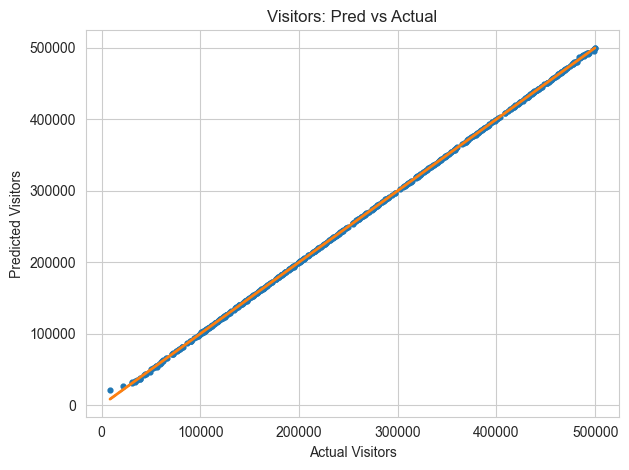

[SPENDING] R²=0.99739, RMSE=372626492


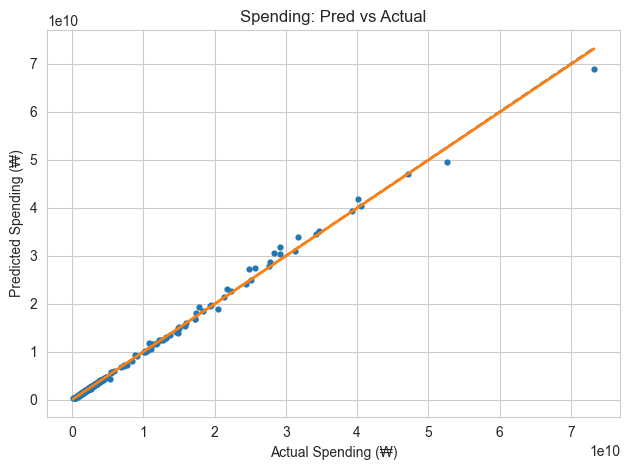

In [40]:
# ============================================
# R² 계산 + 예측 vs 실측 산점도(회귀선 포함) 통합 스크립트
# - 방문자수(model_visitors.pkl)
# - 지출액(model_spending_blend.pkl)
# ============================================
import os, warnings
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LinearRegression, Ridge
from lightgbm import LGBMRegressor

warnings.filterwarnings("ignore")

# ===== 사용자 설정 =====
TARGET_VISITORS = "전체_방문자수"
TARGET_SPENDING = "예상_총지출액(원)"
ID_COL = "축제명"
VIS_PATH = "model_visitors.pkl"
SP_PATH  = "model_spending_blend.pkl"
USE_OOF = False  # True로 두면 5-Fold OOF 성능도 출력

# ===== 공통 유틸 =====
def _coerce_numeric(s):
    try:
        return pd.to_numeric(s, errors="ignore")
    except:
        return s

def make_preprocessors(num_cols, cat_cols):
    # sklearn 버전 호환: OneHotEncoder(sparse_output) ↔ sparse
    try:
        ohe_lin = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
        ohe_tree = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        ohe_lin = OneHotEncoder(handle_unknown="ignore", sparse=True)
        ohe_tree = OneHotEncoder(handle_unknown="ignore", sparse=True)
    pre_lin = ColumnTransformer([("num", StandardScaler(with_mean=False), num_cols),
                                 ("cat", ohe_lin, cat_cols)], remainder="drop")
    pre_tree = ColumnTransformer([("num", "passthrough", num_cols),
                                  ("cat", ohe_tree, cat_cols)], remainder="drop")
    return pre_lin, pre_tree

def plot_pred_vs_actual(y_true, y_pred, title, xlabel, ylabel):
    plt.figure()
    plt.scatter(y_true, y_pred, s=12)
    lo = float(min(y_true.min(), y_pred.min()))
    hi = float(max(y_true.max(), y_pred.max()))
    # 45도 기준선
    plt.plot([lo, hi], [lo, hi], linestyle="--")
    # 회귀선 (yhat = a*y + b)
    a, b = np.polyfit(y_true, y_pred, 1)
    plt.plot([lo, hi], [a*lo + b, a*hi + b], linewidth=2)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout(); plt.show()

# ===== 데이터 준비 =====
# df 는 이미 메모리에 있다고 가정 (제발최종_with_interactions.csv 사용했다면 그 df)
# 없다면 다음 한 줄로 로드:
# df = pd.read_csv("/mnt/data/제발최종_with_interactions.csv")

drop_cols = [ID_COL, TARGET_VISITORS, TARGET_SPENDING, "시작일", "종료일"]
X_cols = [c for c in df.columns if c not in drop_cols]
for c in X_cols:
    df[c] = _coerce_numeric(df[c])

cat_cols = [c for c in X_cols if df[c].dtype=="object" or str(df[c].dtype).startswith("category")]
num_cols = [c for c in X_cols if c not in cat_cols]

X = df[X_cols].copy()
y_vis = df[TARGET_VISITORS].astype(float).values
y_sp  = df[TARGET_SPENDING].astype(float).values
groups = df[ID_COL].astype(str).values

pre_lin, pre_tree = make_preprocessors(num_cols, cat_cols)

# ===== 1) 방문자수: 모델 로드 or 빠른 재학습 =====
if os.path.exists(VIS_PATH):
    vis_art = joblib.load(VIS_PATH)
    vis_pipe = vis_art["pipeline"]
    vis_features = vis_art["features"]
else:
    vis_pipe = Pipeline([
        ("pre", pre_tree),
        ("model", LGBMRegressor(
            n_estimators=300, learning_rate=0.1,
            subsample=0.9, colsample_bytree=0.9,
            random_state=42, n_jobs=8, verbose=-1
        ))
    ])
    if USE_OOF:
        gkf = GroupKFold(n_splits=5)
        oof = np.zeros(len(df))
        for tr, va in gkf.split(X, y_vis, groups=groups):
            vis_pipe.fit(X.iloc[tr], y_vis[tr])
            oof[va] = vis_pipe.predict(X.iloc[va])
        print(f"[VISITORS OOF] R²={r2_score(y_vis, oof):.4f}, RMSE={np.sqrt(mean_squared_error(y_vis, oof)):.2f}")
    vis_pipe.fit(X, y_vis)
    joblib.dump({"pipeline": vis_pipe, "features": X_cols, "cat_cols": cat_cols, "num_cols": num_cols}, VIS_PATH)
    vis_features = X_cols

# R² + 산점도
X_vis = df.reindex(columns=vis_features, fill_value=np.nan)
yhat_vis = vis_pipe.predict(X_vis)
print(f"[VISITORS] R²={r2_score(y_vis, yhat_vis):.5f}, RMSE={np.sqrt(mean_squared_error(y_vis, yhat_vis)):.2f}")
plot_pred_vs_actual(y_vis, yhat_vis, "Visitors: Pred vs Actual", "Actual Visitors", "Predicted Visitors")

# ===== 2) 지출액(블렌딩): 로드 or 빠른 재학습(Ridge + LGBM 2모델 스택) =====
if os.path.exists(SP_PATH):
    sp_art = joblib.load(SP_PATH)
    base_models = sp_art["base_models"]
    meta = sp_art["meta"]
    stack_mean = sp_art["stack_mean"]
    stack_std = sp_art["stack_std"]
    model_names = sp_art["model_names"]
    X_feat = sp_art["features"]
else:
    y_sp_log = np.log1p(y_sp)
    base_models = {
        "Ridge":  Pipeline([("pre", pre_lin),  ("model", Ridge(alpha=1.0, random_state=42))]),
        "LGBM":   Pipeline([("pre", pre_tree), ("model", LGBMRegressor(
            n_estimators=400, learning_rate=0.08,
            subsample=0.9, colsample_bytree=0.9,
            random_state=42, n_jobs=8, verbose=-1
        ))]),
    }
    names = list(base_models.keys())
    if USE_OOF:
        gkf = GroupKFold(n_splits=5)
        oof_stack = np.zeros((len(df), len(names)))
        for i, name in enumerate(names):
            fold_pred = np.zeros(len(df))
            for tr, va in gkf.split(X, y_sp_log, groups=groups):
                base_models[name].fit(X.iloc[tr], y_sp_log[tr])
                fold_pred[va] = base_models[name].predict(X.iloc[va])
            oof_stack[:, i] = fold_pred
        stack_mean = oof_stack.mean(axis=0, keepdims=True)
        stack_std  = oof_stack.std(axis=0, keepdims=True) + 1e-9
        oof_std = (oof_stack - stack_mean) / stack_std
        meta = Ridge(alpha=1.0, random_state=42).fit(oof_std, y_sp_log)
        meta_oof_raw = np.expm1(meta.predict(oof_std))
        print(f"[SPENDING OOF META] R²(raw)={r2_score(y_sp, meta_oof_raw):.4f}, RMSE={np.sqrt(mean_squared_error(y_sp, meta_oof_raw)):.0f}")
    else:
        # OOF 생략: full-fit 기준으로 표준화 파라미터만 0/1로 설정
        stack_mean = np.zeros((1, len(base_models)))
        stack_std  = np.ones((1, len(base_models)))
        meta = Ridge(alpha=1.0, random_state=42)
        # 메타 사전학습을 위해 간이 스택 만들어 적합
        tmp_stack = np.column_stack([m.fit(X, np.log1p(y_sp)).predict(X) for m in base_models.values()])
        meta.fit((tmp_stack - stack_mean) / stack_std, np.log1p(y_sp))

    # full fit 베이스모델
    for name in base_models:
        base_models[name].fit(X, np.log1p(y_sp))
    joblib.dump({
        "base_models": base_models, "meta": meta,
        "stack_mean": stack_mean, "stack_std": stack_std,
        "features": X_cols, "cat_cols": cat_cols, "num_cols": num_cols,
        "model_names": list(base_models.keys()), "target": TARGET_SPENDING
    }, SP_PATH)
    model_names = list(base_models.keys()); X_feat = X_cols

# R² + 산점도 (스택 추론)
X_sp = df.reindex(columns=X_feat, fill_value=np.nan)
stack_now = np.column_stack([base_models[name].predict(X_sp) for name in model_names])
stack_now_std = (stack_now - stack_mean) / (stack_std + 1e-9)
yhat_sp = np.expm1(meta.predict(stack_now_std))

print(f"[SPENDING] R²={r2_score(y_sp, yhat_sp):.5f}, RMSE={np.sqrt(mean_squared_error(y_sp, yhat_sp)):.0f}")
plot_pred_vs_actual(y_sp, yhat_sp, "Spending: Pred vs Actual", "Actual Spending (₩)", "Predicted Spending (₩)")


In [41]:
# ============================================
# Multi-Output LGBM (원핫 인코딩 파이프라인) - 5개 타깃 동시 예측
# ============================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error
import joblib

# 0) 타깃 정의 (있는 것만 자동 사용)
ALL_TARGETS = [
    "전체_방문자수",        # visitors
    "예상_총지출액(원)",     # spending/sales
    "홍보강도지수",         # sns mentions
    "예산(원)",            # annual budget
    "숙박일수",         # staying guests
]

# df = pd.read_csv("제발최종_with_interactions.csv")  # 필요 시 로드
present_targets = [t for t in ALL_TARGETS if t in df.columns]
assert len(present_targets) >= 2, f"타깃 컬럼이 너무 적습니다: {present_targets}"

DROP_COLS = ["축제명", "시작일", "종료일"] + present_targets
X_cols = [c for c in df.columns if c not in DROP_COLS]

# 1) 타입 정리: 숫자 캐스팅(가능한 경우), 범주형 자동 감지
def _coerce_numeric(s):
    try:
        return pd.to_numeric(s, errors="ignore")
    except:
        return s
for c in X_cols:
    df[c] = _coerce_numeric(df[c])

cat_cols = [c for c in X_cols if df[c].dtype == "object" or str(df[c].dtype).startswith("category")]
num_cols = [c for c in X_cols if c not in cat_cols]

X = df[X_cols].copy()
Y = df[present_targets].copy()

# 2) 전처리 파이프라인: 수치(StandardScaler) + 범주(OneHot, handle_unknown='ignore')
#    sklearn 버전 호환: sparse_output 인자 문제 회피
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),
        ("cat", ohe, cat_cols),
    ],
    remainder="drop"
)

# 3) 멀티아웃풋 회귀 모델 (LGBM)
base = LGBMRegressor(
    n_estimators=600,
    learning_rate=0.06,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=8
)
model = MultiOutputRegressor(base)

pipe = Pipeline([
    ("pre", preprocess),
    ("reg", model)
])

# 4) Train / Test split (재현성)
X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size=0.2, random_state=42)

# 5) 학습
pipe.fit(X_tr, y_tr)

# 6) 평가
y_pred = pipe.predict(X_te)
for i, t in enumerate(present_targets):
    r2  = r2_score(y_te.iloc[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_te.iloc[:, i], y_pred[:, i]))
    print(f"{t:>12s} | R²={r2: .4f}  RMSE={rmse:,.2f}")

# 7) 저장 + 추론 유틸
ART_PATH = "multiout_lgbm.pkl"
joblib.dump({
    "pipeline": pipe,
    "features": X_cols,
    "targets": present_targets,
    "num_cols": num_cols,
    "cat_cols": cat_cols
}, ART_PATH)
print(f"저장 완료: {ART_PATH}")

def predict_multi(df_new: pd.DataFrame, art_path=ART_PATH):
    art = joblib.load(art_path)
    req_cols = art["features"]
    pipe = art["pipeline"]
    Xn = df_new.reindex(columns=req_cols, fill_value=np.nan).copy()
    return pd.DataFrame(pipe.predict(Xn), columns=art["targets"])


     전체_방문자수 | R²= 0.9942  RMSE=10,255.54
  예상_총지출액(원) | R²= 0.9371  RMSE=1,600,214,677.85
      홍보강도지수 | R²= 0.9937  RMSE=0.02
       예산(원) | R²= 0.9900  RMSE=5,343,222.40
        숙박일수 | R²= 0.9309  RMSE=0.15
저장 완료: multiout_lgbm.pkl


✅ 한글 폰트 적용 완료: Malgun Gothic
✔ Pearson 저장: /mnt/data\corr_pearson.csv
✔ Spearman 저장: /mnt/data\corr_spearman.csv


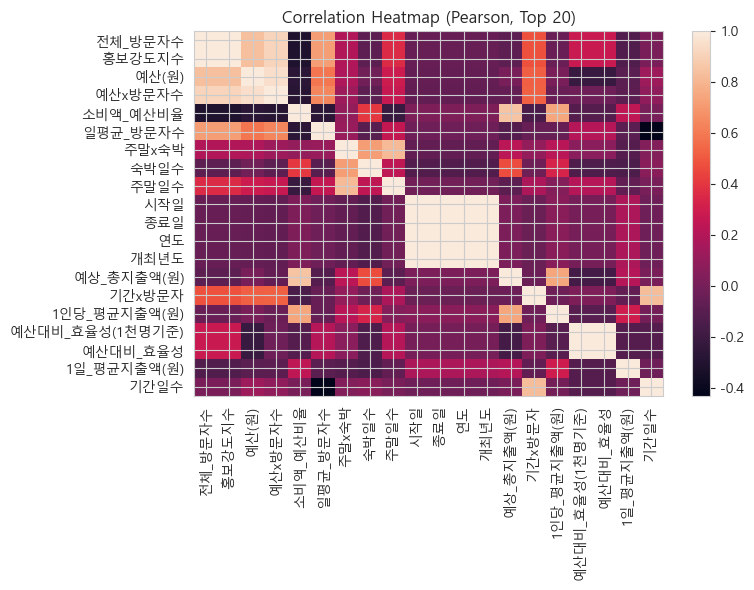

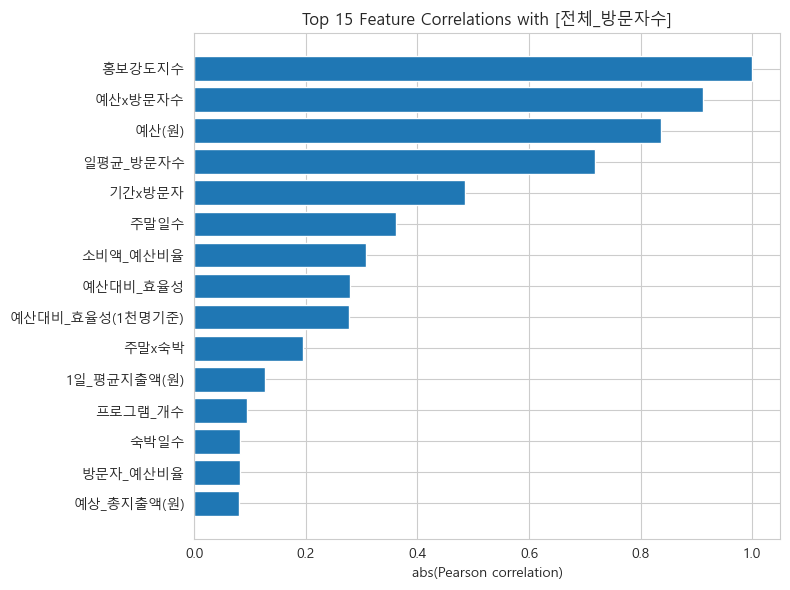

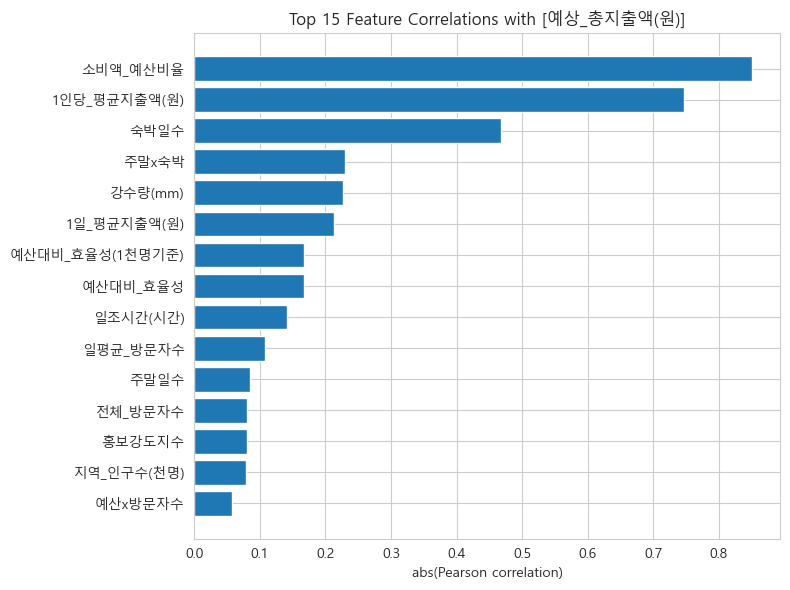

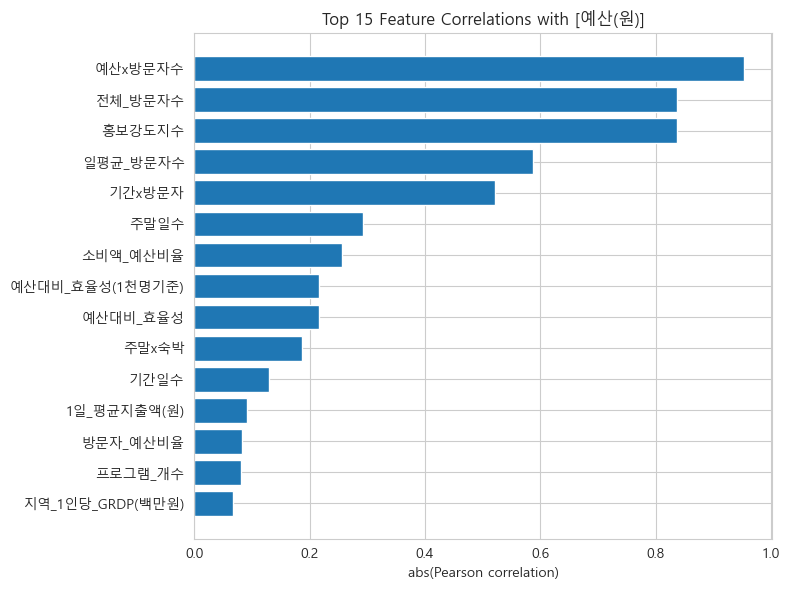

In [52]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# -------------------------
# 한글 폰트 설정
# -------------------------
if platform.system() == "Windows":
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕
elif platform.system() == "Darwin":  # macOS
    font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"
else:  # Colab, Linux
    !apt-get -qq -y install fonts-nanum > /dev/null
    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc("font", family=font_name)

# 마이너스 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

print("✅ 한글 폰트 적용 완료:", font_name)

# ============================================
# 상관관계 분석(피어슨/스피어만) + 히트맵 + 타깃별 TOP-N 바차트
# ============================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 메인 함수 ---------------------------------------------------
def run_correlation(
    df: pd.DataFrame,
    targets=("전체_방문자수", "예상_총지출액(원)", "예산(원)"),
    topn_heatmap=20,
    topn_bars=15,
    save_dir="/mnt/data"
):
    # 1) 숫자형만 선택 + 결측/inf 처리
    num_df = df.select_dtypes(include=[np.number]).copy()
    if num_df.shape[1] < 2:
        raise ValueError("숫자형 컬럼이 2개 미만입니다. 상관분석 불가.")
    num_df = num_df.replace([np.inf, -np.inf], np.nan)
    num_df = num_df.fillna(num_df.median(numeric_only=True))

    # 2) 상관행렬 계산
    corr_pearson = num_df.corr(method="pearson")
    corr_spearman = num_df.corr(method="spearman")

    # 3) 저장
    os.makedirs(save_dir, exist_ok=True)
    pearson_path = os.path.join(save_dir, "corr_pearson.csv")
    spearman_path = os.path.join(save_dir, "corr_spearman.csv")
    corr_pearson.to_csv(pearson_path, encoding="utf-8-sig")
    corr_spearman.to_csv(spearman_path, encoding="utf-8-sig")
    print(f"✔ Pearson 저장: {pearson_path}")
    print(f"✔ Spearman 저장: {spearman_path}")

    # 4) 히트맵(피어슨) — 절대 상관합 기준 상위 N개 변수
    abs_sum = corr_pearson.abs().sum().sort_values(ascending=False)
    top_cols = list(abs_sum.head(min(topn_heatmap, len(abs_sum))).index)
    corr_top = corr_pearson.loc[top_cols, top_cols]

    plt.figure(figsize=(8, 6))
    plt.imshow(corr_top, aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(top_cols)), top_cols, rotation=90)
    plt.yticks(range(len(top_cols)), top_cols)
    plt.title(f"Correlation Heatmap (Pearson, Top {len(top_cols)})")
    plt.tight_layout()
    plt.show()

    # 5) 타깃별 TOP-N 상관 바차트(피어슨 |corr|)
    present_targets = [t for t in targets if t in num_df.columns]
    for tgt in present_targets:
        s = corr_pearson[tgt].drop(tgt, errors="ignore").dropna()
        s_abs = s.abs().sort_values(ascending=False)
        top_feats = s_abs.head(min(topn_bars, len(s_abs)))

        plt.figure(figsize=(8, 6))
        plt.barh(top_feats.index[::-1], top_feats.values[::-1])
        plt.xlabel("abs(Pearson correlation)")
        plt.title(f"Top {len(top_feats)} Feature Correlations with [{tgt}]")
        plt.tight_layout()
        plt.show()

    # 6) 상위 10개 미리보기 리턴
    cols10 = list(abs_sum.head(min(10, len(abs_sum))).index)
    preview = corr_pearson.loc[cols10, cols10]
    return {"pearson": corr_pearson, "spearman": corr_spearman, "preview": preview}




out = run_correlation(df)